In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
import jax
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.metrics import roc_curve, auc

Link to the [dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

In [ ]:
data = pd.read_csv('drive/MyDrive/creditcard.csv', delimiter=',')

## Data inspection

Display some basic information.

In [ ]:
data.head()

In [ ]:
n_samples = data.shape[0]
n_features = data.shape[1] - 1 # 'Class' is not a feature
n_frauds = np.sum(data['Class'])

print('%d samples' %n_samples)
print('%d features' %n_features)
print('%d frauds' %n_frauds)

In [ ]:
data.info() # there aren't null values

In [ ]:
data.describe() 

## Attribute vectors

In [ ]:
# Make the attribute vectors with the GA selected features
v1 = ['V1', 'V5', 'V7', 'V8', 'V11', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'Amount', 'Class'] # 'Class' added
data_1 = data[v1] 
v2 = ['V1', 'V6', 'V13', 'V16', 'V17', 'V22', 'V23', 'V28', 'Amount', 'Class']
data_2 = data[v2]
v3 = ['V2', 'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V20', 'V21', 'V24', 'V26', 'Amount', 'Class']
data_3 = data[v3]
v4 = ['V2', 'V7', 'V10', 'V13', 'V15', 'V17', 'V19', 'V28', 'Amount', 'Class']
data_4 = data[v4]
v5 = ['Time', 'V1', 'V7', 'V8', 'V9', 'V11', 'V12', 'V14', 'V15', 'V22', 'V27', 'V28', 'Amount', 'Class']
data_5 = data[v5]
# dataset with full feature vector
data_6 = data.copy()
# dataset with random feature vector
v_random = ['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V11', 'V12', 'V13', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V25', 'V26', 'V28', 'Amount', 'Class']
data_7 = data[v_random]

In [ ]:
data_2.corr() # this and the following plots are not readable with the entire dataset, maybe do this just for the selected features

In [ ]:
_, ax = plt.subplots(figsize=(22,10))
sns.heatmap(data_2.corr(), annot = True, cmap = 'vlag_r', vmin = -1, vmax = 1,  ax = ax) 

In [ ]:
data_mean = data_2.mean()
data_std = data_2.std()
data_normalized = (data_2 - data_mean) / data_std # don't override data, once trained the model go back in the real world to predict there, not in the normalized world

data_normalized.describe()

In [ ]:
_, ax = plt.subplots(figsize=(22,10))
sns.violinplot(data = data_normalized, ax = ax)

## Data normalization

Min-max scaling method.

In [ ]:
def min_max(data):
  '''
  Applies the min-max scaling method to a numpy dataset

  Parameters
  ----------
  data : ndarray
    dataset to scale with samples on rows

  Returns
  -------
  data_normalized : ndarray
    original dataset but normalized
  '''

  data_min = data.min(axis=0)
  data_max = data.max(axis=0)
  data_normalized = (data - data_min[None,:]) / (data_max[None,:] - data_min[None,:]) 
  return data_normalized

## Train-validation split


In [ ]:
# maybe use cross-validation
# 60% train, 20% validation, 20% test, maybe it is not necessary having the validation

def train_split(data_input, percentage_train=0.6, percentage_validation=0.2):
  '''
  Shuffles the dataset and splits in train, validation and test

  Parameters
  ----------
  data_input : ndarray
    dataset to split with samples on rows
  percentage_train : float
    percentage of data to put in the train dataset
  percentage_validation : float
    percentage of data to put in the validation dataset

  Returns
  -------
  x_train : ndarray
    train dataset with samples
  y_train : ndarray
    train dataset with labels
  x_valid : ndarray
    validation dataset with samples
  y_valid : ndarray
    validation dataset with labels
  x_test : ndarray
    test dataset with samples
  y_test : ndarray
    test dataset with labels

  Raises
  ------
  Exception : if the sum of the two percentages is greater than 1 or at least 
              one of them is negative
  '''

  # check validity of the parameters
  if percentage_train + percentage_validation > 1 or percentage_train < 0 or\
    percentage_validation < 0:
    raise Exception('Percentages must be positive and their sum must be lower \
                    or equal to 1')
    
  data = data_input.copy()

  np.random.seed(0) # for reproducibility
  np.random.shuffle(data) # shuffle along first axis so rows

  # take the number of samples to put in each dataset
  num_train = int(data.shape[0] * percentage_train) 
  num_val = num_train + int(data.shape[0] * percentage_validation) 

  # split the dataset
  x_train = data[:num_train, :-1] #don't take last column that is the class
  y_train = data[:num_train, -1:]
  x_valid = data[num_train:num_val, :-1]
  y_valid = data[num_train:num_val, -1:]
  x_test =  data[num_val:, :-1] 
  y_test =  data[num_val:, -1:]

  return x_train, y_train, x_valid, y_valid, x_test, y_test

##Undersampling

In [ ]:
# undersample the majority class, this will create a balanced dataset, allowing the classifier to better distinguish between the two classes.

def undersample(x, y, ratio):
  '''
  Performs undersampling on the dataset

  Parameters
  ----------
  x : ndarray
    dataset to undersample with samples on 
  y : ndarray
    corresponding labels of the dataset to undersample
  ratio : float
    desired ratio of samples between majority and minority class.
    It assumes that label '1' is the minority class

  Returns
  -------
  x[idxs, :] : ndarray
    dataset undersampled with samples
  y[idxs, :] : ndarray
    corresponding labels of the undersampled dataset
  '''

  # take indexes corresponding to labels '0' and '1'
  idxs_zeros = np.where(y == 0.)[0]
  idxs_ones = np.where(y == 1.)[0]

  # compute the number of samples of the majority class to keep
  n_samples = int(len(idxs_ones) * ratio)

  # extract randomly the samples from the majority class
  idxs_zeros = np.random.choice(idxs_zeros, min(n_samples, len(idxs_zeros)), replace = False)
  
  # extract the undersampled dataset
  idxs = np.concatenate((idxs_zeros, idxs_ones))
  return x[idxs, :], y[idxs, :]

##Metrics

In [ ]:
# Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise

def metrics(predictions, true_labels, axis=None):
  '''
  Computes and print metrics TP, TN, FP, FN, AC, RC, PC, F1

  Parameters
  ----------
  predictions : ndarray
    predictions of samples obtained with a model
  true_labels : ndarray
    true labels of the samples
  axis : matplotlib.axes._subplots.AxesSubplot, optional
    to print the outputs on a box in a plot
  '''

  TP = np.sum(np.logical_and(predictions == 1., true_labels == 1.)) # attacks accurately flagged as attacks
  TN = np.sum(np.logical_and(predictions == 0., true_labels == 0.)) # normal traffic accurately flagged as normal
  FP = np.sum(np.logical_and(predictions == 1., true_labels == 0.)) # normal traffic incorrectly flagged as attacks
  FN = np.sum(np.logical_and(predictions == 0., true_labels == 1.)) # attacks incorrectly flagged as normal 

  AC = ((TN + TP) / len(predictions)) * 100 # accuracy
  RC = (TP / (FN + TP)) * 100 # recall or sensitivity
  PR = (TP / (FP + TP)) * 100 # precision
  F1 = 2 * PR * RC / (PR + RC) # F1-Score

  if axis is None:
    # print the values
    print('TP: %d' % TP)
    print('TN: %d' % TN)
    print('FP: %d' % FP)
    print('FN: %d' % FN)
    print('accuracy: %1.2f%%' % AC)
    print('recall: %1.2f%%' % RC)
    print('precision: %1.2f%%' % PR)
    print('F1-Score: %1.2f%%' % F1)
  else:
    # print values on a plot
    text = 'accuracy %1.2f%%\nrecall: %1.2f%%\nprecision: %1.2f%%\nF1-Score: %1.2f%%' % (AC, RC, PR, F1)
    axis.annotate(text, xy=(0.75, 0.75), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.8", fc=(.5, 1., 1.)),
             fontsize=14, color='black')

In [ ]:
# Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise

def metricsDF(predictions, true_labels, metrics_df=None, dataset_label='NotLabeled'):
  """
  Computes and print metrics TP, TN, FP, FN, AC, RC, PC, F1

  Parameters
  ----------
  predictions: ndarray
  true_labels: ndarray
  metrics_df: DataFrame
  dataset_label: str

  Returns
  -------
  DataFrame
  
  """

  TP = np.sum(np.logical_and(predictions == 1., true_labels == 1.)) # attacks accurately flagged as attacks
  TN = np.sum(np.logical_and(predictions == 0., true_labels == 0.)) # normal traffic accurately flagged as normal
  FP = np.sum(np.logical_and(predictions == 1., true_labels == 0.)) # normal traffic incorrectly flagged as attacks
  FN = np.sum(np.logical_and(predictions == 0., true_labels == 1.)) # attacks incorrectly flagged as normal 

  AC = ((TN + TP) / len(predictions)) * 100 # accuracy
  RC = (TP / (FN + TP)) * 100 # recall or sensitivity
  PR = (TP / (FP + TP)) * 100 # precision
  F1 = 2 * PR * RC / (PR + RC) # F1-Score

  if metrics_df is None:
    columns = ['Set of features', 'TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score']
    metrics_df = pd.DataFrame([[dataset_label, TP, TN, FP, FN, AC, RC, PR, F1]], columns=columns)
  else:
    columns = ['Set of features', 'TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score']
    metrics_df = metrics_df.append(pd.DataFrame([[dataset_label, TP, TN, FP, FN, AC, RC, PR, F1]], columns=columns))
  
  return metrics_df

##Logistic regression

In [ ]:
# can add more loss, like accuracy and MSE(se vuoi sotto in ANN sono definiti, ma con params = [bias, weights] e quind x = [1,x] o simile)
# penalize more error on frauds not detected, so the model pays more attention to this minority class

def MSE(x, y, weights, bias):
  '''
  Computes the mean squared error.
  '''

  # compute prediction
  y_pred = 1 / (1 + jnp.exp(-(bias + x @ weights)))
  # compute loss
  return jnp.mean(jnp.square(y - y_pred))

def cross_entropy(x, y, weights, bias):
  '''
  Cross entropy cost function

  Parameters
  ----------
  x : ndarray
    samples
  y : ndarray
    true labels associated to samples
  weights : ndarray
    weights of the model
  bias : float
    bias of the model

  Returns
  -------
  ndarray
    the value of the cost function with the given input
  '''

  # compute prediction
  y_pred = 1 / (1 + jnp.exp(-(bias + x @ weights)))
  # compute loss
  return - jnp.mean(2. * y * jnp.log(y_pred) + 0.5 * (1-y) * jnp.log(1-y_pred)) 

# gradient computation and jit compilation of the cost function
grad = jax.grad(cross_entropy, argnums = [2,3])
grad_jit = jax.jit(grad)
cross_entropy_jit = jax.jit(cross_entropy)

grad = jax.grad(MSE, argnums = [2,3])
grad_MSE_jit = jax.jit(grad)
MSE_jit = jax.jit(MSE)

In [ ]:
# using vanilla SGD, so without learning rate decay and batch size doesn't work
# tried RMSPROP, doesn't work well
# we could add the callback

def SGD(x_train, y_train, x_valid=None, y_valid = None, num_epochs=50000, learning_rate_max=1e-1, \
        learning_rate_min = 1e-3, learning_rate_decay = 50000, batch_size = 32):
  '''
  SGD method with mini-batch and learning rate decay

  Parameters
  ----------
  x_train : ndarray
    train dataset with samples on rows
  y_train : ndarray
    train labels
  x_train : ndarray, optional
    validation dataset with samples on rows
  y_train : ndarray, optional
    validation labels
  num_epochs : int
    number of epochs to perform (default is 50000)
  learning_rate_max : float
    max value of the learning rate (default is 1e-1)
  learning_rate_min : float
    min value of the learning rate (default is 1e-3)
  learning_rate_decay : int
    number of epochs to reach the learning_rate_min (default is 50000)
  batch_size : int
    size of the batch (default is 32)

  Returns
  -------
  weights : ndarray
    computed weights of the model
  bias : float
    computed bias of the model
  history : list
    list with the history of the cost function values on training dataset
  '''

  # check if there is a validation dataset
  validation = True if x_valid is not None and y_valid is not None else False

  # initialize weights and bias
  weights = np.random.randn(x_train.shape[1], 1) 
  bias = 0.0

  # initialize history of the cost function
  history = list()
  history.append(cross_entropy_jit(x_train, y_train, weights, bias))
  if validation:
    history_valid = list()
    history_valid.append(cross_entropy_jit(x_valid, y_valid, weights, bias))


  for epoch in tqdm(range(num_epochs)):  
    # take indexes of the batch
    idxs = np.random.choice(x_train.shape[0], batch_size) 

    # compute gradient
    grads = grad_jit(x_train[idxs,:], y_train[idxs,:], weights, bias)
    
    # compute learning rate value
    learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))
    
    # update weights and bias
    weights -= learning_rate * grads[0]
    bias -= learning_rate * grads[1]

    # compute value of the cost function on entire dataset, it is done periodically because
    # if the dataset is big, this operation slows down too much the function
    if epoch % 10 == 0:
      history.append(cross_entropy_jit(x_train, y_train, weights, bias)) 
      if validation:
        history_valid.append(cross_entropy_jit(x_valid, y_valid, weights, bias))

  #fig, axs = plt.subplots(1,1,figsize=(15,10))
  #print('train loss: %1.3e' % history[-1]) #confrontare con altre loss, es mse o accuracy
  #axs.plot(history, label='train')
  #if validation:
  #  print('validation loss: %1.3e' % history_valid[-1]) #confrontare con altre loss, es mse o accuracy
  #  axs.plot(history_valid, label='validation')
  #axs.legend()

  return weights, bias, history

In [116]:
def predict_LR(x, weights, bias):
  '''
  Predicts output values using logistic regression

  Parameters
  ----------
  x : ndarray
    samples
  weights : ndarray
    weights of the logistic regression model
  bias : float
    bias of the logistic regression model

  Returns
  -------
  predictions : ndarray
    array with values of the samples predicted with the given model
  '''
  return 1. / (1. + np.exp(-(bias + x @ weights)))

def predict_label_LR(x, weights, bias):
  '''
  Predicts labels using logistic regression

  Parameters
  ----------
  x : ndarray
    samples
  weights : ndarray
    weights of the logistic regression model
  bias : float
    bias of the logistic regression model

  Returns
  -------
  predictions : ndarray
    array with labels of the samples predicted with the given model
  '''

  # predict output of samples with the model
  y_pred = predict_LR(x, weights, bias)

  # link the predicted output to the label
  predictions = np.array([0. if pred < 0.5 else 1. for pred in y_pred])[:, None] # by setting the threshold at 0.4 better results
  return predictions

## Testing LR

In [ ]:
# test LR on a single dataset

# set up the datasets
data_np = data_5.to_numpy()
data_normalized_np = min_max(data_np)
x_train, y_train, _, _, x_test, y_test = train_split(data_normalized_np, percentage_train=0.7, percentage_validation=0.0)
x_train, y_train = undersample(x_train, y_train, 50.)

# train model
weights, bias, history = SGD(x_train, y_train) 

# plot history of the values of loss function
fig, axs = plt.subplots(1,1,figsize = (15,10)) 
axs.plot(history)
axs.set_title('train loss: %1.3e' % history[-1])

# get predictions with the trained model
predictions = predict_label_LR(x_test, weights, bias) 

# compute metrics
metrics(predictions, y_test)

  0%|          | 0/50000 [00:00<?, ?it/s]

AUC: 0.95


  0%|          | 0/50000 [00:00<?, ?it/s]

AUC: 0.81


  0%|          | 0/50000 [00:00<?, ?it/s]

AUC: 0.93


  0%|          | 0/50000 [00:00<?, ?it/s]

AUC: 0.83


  0%|          | 0/50000 [00:00<?, ?it/s]

AUC: 0.96


  0%|          | 0/50000 [00:00<?, ?it/s]

AUC: 0.99


  0%|          | 0/50000 [00:00<?, ?it/s]

AUC: 0.97


Text(0, 0.5, 'True Positive Rate')

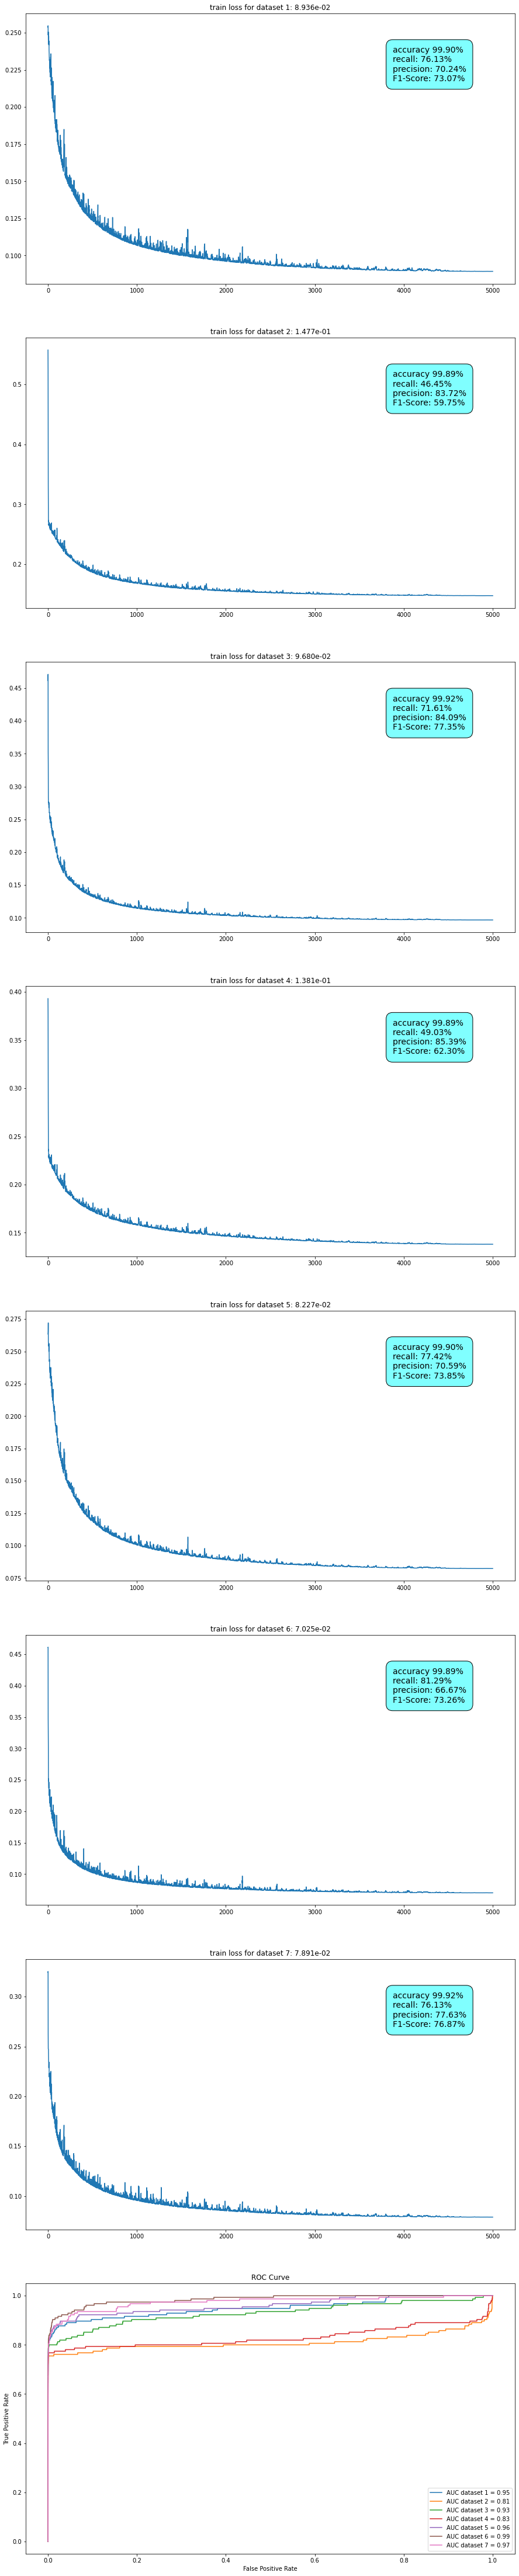

In [117]:
# testing LR on all datasets 
datasets = [data_1, data_2, data_3, data_4, data_5, data_6, data_7]
fig, axs = plt.subplots(8,1,figsize = (15,80)) 

for i, dataset in enumerate(datasets):
  # set up the datasets
  dataset_np = dataset.to_numpy()
  dataset_normalized_np = min_max(dataset_np)
  x_train, y_train, _, _, x_test, y_test = train_split(dataset_normalized_np, percentage_train=0.7, percentage_validation=0.0)
  x_train, y_train = undersample(x_train, y_train, 20.)

  # train model
  weights, bias, history = SGD(x_train, y_train, batch_size=4) 

  # plot history of the values of loss function
  axs[i].plot(history)
  axs[i].set_title('train loss for dataset %d: %1.3e' % (i+1, history[-1]))

  # get predictions with the trained model
  predictions = predict_label_LR(x_test, weights, bias) 

  # compute metrics
  metrics(predictions, y_test, axs[i]) 
  #works well also with 30 undersample and batch_size=8

  y_pred = predict_LR(x_test, weights, bias)
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)

  print("AUC: %.2f" % roc_auc)
  # Plot the ROC curve
  axs[7].plot(fpr, tpr, label='AUC dataset %d = %0.2f' % (i+1, roc_auc))
  
axs[7].set_title('ROC Curve')
axs[7].legend(loc='lower right')
axs[7].set_xlabel('False Positive Rate')
axs[7].set_ylabel('True Positive Rate')

##Decision tree

In [ ]:
class Node: 
  '''
  Class representing a node in a DecisionTree

  Attributes
  ----------
  feature : int
    feature associated to the node
  threshold : float
    threshold associated to the feature
  left : Node
    left child of the node
  right : Node
    right child of the node
  value : float
    label associated to the node, if leaf

  Methods
  -------
  is_leaf : tell if a Node is a leaf or not
  '''
 
  def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
    '''
    Parameters
    ----------
    feature : int
      feature associated to the node (default is None)
    threshold : float
      threshold associated to the feature (default is None)
    left : Node
      left child of the node (default is None)
    right : Node
      right child of the node (default is None)
    value : float
      label associated to the node, if leaf (default is None)
    '''

    self.feature = feature
    self.threshold = threshold
    self.left = left
    self.right = right
    self.value = value

  def is_leaf(self):
    '''
    Tells if the node is a leaf
    '''

    return self.value is not None


class DecisionTree:
  '''
  Class representing a decision tree

  Attributes
  ----------
  max_depth : int
    max depth of a tree
  n_features : int
    number of features to evaluate while branching to build a tree
  max_number_thresholds : int
    max number of thresholds to evaluate while branching to build a tree
  min_samples : int
    min number of samples in a node to branch when building a tree
  root : root of the tree
  mode : str
      mode to compute the information gain, it can be 'gini' or 'entropy'
  
  Methods
  -------
  train : to train a decision tree model
  predict : to make predictions using the built model
  '''

  def __init__(self, max_depth=10, n_features=None, max_number_thresholds=np.inf, min_samples=2, mode='gini'):
    '''
    Parameters
    ----------
    max_depth : int
      max depth of a tree (default is 10)
    n_features : int
      number of features to evaluate while branching to build a tree (default is None)
    max_number_thresholds : int
      max number of thresholds to evaluate while branching to build a tree (default is np.inf)
    min_samples : int
      min number of samples in a node to branch when building a tree (default is 2)
    mode : str
      mode to compute the information gain, it can be 'gini' or 'entropy' (default is 'gini')
    '''

    self.max_depth = max_depth 
    self.n_features = n_features 
    self.max_number_thresholds = max_number_thresholds 
    self.min_samples = min_samples  
    self.root = None
    self.mode = mode

  def train(self, x, y):
    '''
    Builds the tree

    Parameters
    ----------
    x : ndarray
      train dataset with samples on rows 
    y : ndarray
      labels associated to the dataset
    '''

    if self.n_features is None or self.n_features > x.shape[1]:
      self.n_features = x.shape[1] 
    self.root = self.build_tree(x, y)
      
  def build_tree(self, x, y, depth=0):
    '''
    Builds the tree recursively and returns the root

    Parameters
    ----------
    x : ndarray
      train dataset with samples on rows
    y : ndarray
      labels associated to the dataset
    depth : int
      current depth of the tree

    Returns
    -------
    Node
      the root of the built tree
    '''

    num_samples, num_features = x.shape
    num_values = len(np.unique(y)) # get number of different values in y 

    # check the stopping criteria, if so create a leaf node
    if depth >= self.max_depth or num_samples < self.min_samples or num_values <= 1:
      return Node(value = self.get_value(y))

    # randomly select the features to evaluate
    features = np.random.choice(num_features, self.n_features, replace=False)

    # to select the best branch
    max_gain = -1
    branch_threshold= None
    branch_feature = None

    #print('split')
    # evaluate all selected features
    for feature in features:
      # randomly select the thresholds to evaluate
      thresholds = np.random.choice(np.unique(x[:, feature]), 
                                    min(self.max_number_thresholds, len(np.unique(x[:, feature]))), replace=False)

      # evaluate all selected thresholds
      for threshold in thresholds:
        # compute the information gain
        gain = self.gain(x[:, feature], y, threshold)

        # check if it is the best gain
        if gain > max_gain:
          max_gain = gain
          branch_threshold = threshold
          branch_feature = feature

    # build left branch
    left_idxs = x[:, branch_feature] <= branch_threshold
    left = self.build_tree(x[left_idxs, :], y[left_idxs, :], depth+1)

    # build right branch
    right_idxs = x[:, branch_feature] > branch_threshold
    right = self.build_tree(x[right_idxs, :], y[right_idxs, :], depth+1)

    return Node(branch_feature, branch_threshold, left, right)
        
  # TODO
  def gain(self, x, y, threshold):
    '''
    Computes the information gain using gini or entropy

    Parameters
    ----------
    x : ndarray
      train dataset with samples on rows
    y : ndarray
      labels associated to the dataset
    threshold : float
      threshold to divide the samples
    
    Returns
    -------
    float
      the value of the information gain 
    '''

    # take indexes of left and right children
    left_idxs = x <= threshold
    right_idxs = x > threshold

    # if one of the children is empty nothing is changing, so the gain is 0
    if np.sum(left_idxs) == 0 or np.sum(right_idxs) == 0:
      return 0.

    # compute the weights of the children
    weight_left = np.sum(left_idxs) / len(y)
    weight_right = np.sum(right_idxs) / len(y)

    # compute information gain based on the mode
    if self.mode == 'gini':
      return self.gini(y) - (weight_left * self.gini(y[left_idxs, :]) + weight_right * self.gini(y[right_idxs, :]))
    elif self.mode == 'entropy':
      return self.entropy(y) - (weight_left * self.entropy(y[left_idxs, :]) + weight_right * self.entropy(y[right_idxs, :]))

  def gini(self, y):
    '''
    Computes the gini index of a vector of labels

    Parameters
    ----------
    y : ndarray
      vector of labels containing values 0. or 1.

    Returns
    -------
    float
      the value of the gini index
    '''

    # compute probability of having 1. and 0.
    p_ones = np.sum(y) / len(y)
    p_zeros = 1. - p_ones

    # compute gini index
    return 1. - (p_zeros**2 + p_ones**2)

  def entropy(self, y): # using gini would not require the logarithm, more efficient
    '''
    Computes the entropy of a vector of labels

    Parameters
    ----------
    y : ndarray
      vector of labels containing values 0. or 1. 

    Returns
    -------
    float
      the entropy of the vector
    '''

    # compute probability of having 1. and 0.
    p_ones = np.sum(y) / len(y)
    p_zeros = 1. - p_ones

    # compute entropy
    # to avoid computing logarithm of 0.
    if p_ones == 0.:
      return - p_zeros * np.log(p_zeros)
    if p_zeros == 0.:
      return -  p_ones * np.log(p_ones)
    return -(p_zeros * np.log(p_zeros) + p_ones * np.log(p_ones))

  def get_value(self, y):
    '''
    Finds the most common label in a vector

    Parameters
    ----------
    y : ndarray
      vector of labels containing values 0. or 1.

    Returns
    -------
    float
      the value of the most common label
    '''

    ones = np.sum(y)
    zeros = len(y) - ones
    return 1. if ones >= zeros else 0.

  def predict(self, x):
    '''
    Returns the predictions on the input dataset

    Parameters
    ----------
    x : ndarray
      test dataset with samples on rows

    Returns
    -------
    ndarray
      predicted labels
    '''
    
    # compute prediction for each sample of the input
    return np.array([self.get_prediction(sample, self.root) for sample in x])[:,None] # return a column vector

  def get_prediction(self, x, node):
    '''
    Recursively traverse the tree to make a prediction

    Parameters
    ----------
    x : ndarray
      sample to predict
    node : Node
      current node of the tree

    Returns
    -------
    float
      predicted label
    '''

    # if the node is a leaf return the prediction
    if node.is_leaf():
      return node.value
    
    # if the value of the sample corresponding to the feature of the node 
    # is less than the threshold of the node go left, otherwise go right
    if x[node.feature] <= node.threshold:
      return self.get_prediction(x, node.left)
    else:
      return self.get_prediction(x, node.right)

##Testing DT

In [ ]:
# test DT on a single dataset

# set up the datasets
data_np = data_4.to_numpy()
data_normalized_np = min_max(data_np)
x_train, y_train, _, _, x_test, y_test = train_split(data_normalized_np, percentage_train=0.7, percentage_validation=0.0)

# train model
classifier = DecisionTree(max_depth=7, n_features=4, max_number_thresholds=100, min_samples=5) # higher max_thresh performs better but takes more time to train
classifier.train(x_train, y_train)

# get predictions with the trained model
predictions = classifier.predict(x_test)

# compute metrics
metrics(predictions, y_test) 

# pruning, or require a minimum number of samples per leaf per non rischiare overfitting

In [ ]:
# testing DT on all datasets 
datasets = [data_1, data_2, data_3, data_4, data_5, data_6, data_7]

for i, dataset in enumerate(datasets):
  # set up the datasets
  dataset_np = dataset.to_numpy()
  dataset_normalized_np = min_max(dataset_np)
  x_train, y_train, _, _, x_test, y_test = train_split(dataset_normalized_np, percentage_train=0.7, percentage_validation=0.0)
  x_train, y_train = undersample(x_train, y_train, 200.)

  # train model
  classifier = DecisionTree(max_depth=7, max_number_thresholds=50) # higher max_thresh performs better but takes more time to train
  classifier.train(x_train, y_train)

  # get predictions with the trained model
  predictions = classifier.predict(x_test)

  # compute metrics
  print("Metrics for dataset %d" %(i+1))
  metrics(predictions, y_test) 

  fpr, tpr, thresholds = roc_curve(y_test, predictions)
  roc_auc = auc(fpr, tpr)

  print("AUC: %.2f" % roc_auc)
  # Plot the ROC curve
  plt.plot(fpr, tpr, label='AUC dataset %d = %0.2f' % (i+1, roc_auc))
  
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Random forest

In [ ]:
# magari  validare gli alberi sulla restante parte del dataset e tenere solo i migliori? Non so se il risultato possa migliorare
class RandomForest:
  '''
  Class representing a random forest

  Attributes
  ----------
  n_trees : int 
    number of trees in the forest
  max_depth : int 
    max depth of a tree
  n_features : int
    number of features to evaluate while branching to build a tree
  max_number_thresholds : int
    max number of thresholds to evaluate while branching to build a tree
  min_samples : int
    min number of samples in a node to branch when building a tree
  trees : list
    list with all the trees

  Methods
  -------
  train : to train a random forest model
  predict : to make predictions using the built model
  '''

  def __init__(self, n_trees=50, max_depth=10, n_features=None, max_number_thresholds=np.inf, min_samples=2):
    '''
    Parameters
    ----------
    n_trees : int
      number of trees in the forest (default is 50)
    max_depth : int
      max depth of a tree (default is 10)
    n_features : int
      number of features to evaluate while branching to build a tree (default is None)
    max_number_thresholds : int
      max number of thresholds to evaluate while branching to build a tree (default is np.inf)
    min_samples : int
      min number of samples in a node to branch when building a tree (default is 2)
    '''

    self.n_trees = n_trees
    self.max_depth = max_depth 
    self.n_features = n_features 
    self.max_number_thresholds = max_number_thresholds 
    self.min_samples = min_samples
    self.trees = []
  
  def train(self, x, y):
    '''
    Builds the forest

    Parameters
    ----------
    x : ndarray
      train dataset with samples on rows 
    y : ndarray
      labels associated to the dataset
    ''' 

    for i in tqdm(range(self.n_trees)):
      # create bootstrapped dataset
      n_samples = x.shape[0]
      idxs = np.random.choice(n_samples, n_samples, replace=True) # with replacement
      
      # train a tree
      tree = DecisionTree(self.max_depth, self.n_features, self.max_number_thresholds, self.min_samples)
      tree.train(x[idxs, :], y[idxs, :])
      self.trees.append(tree)

  # obviously this require a hyperparametr more to tune
  def validate(self, x, y, parameter):
    votes = np.array([tree.predict(x) for tree in self.trees])
    votes = votes.reshape((votes.shape[1], votes.shape[0]))
    check = votes == y
    check = np.sum(check, axis=0) / len(y)
    print(check)
    survive = check >= parameter
    print('survived %d trees' %(np.sum(survive)))
    for i, e in reversed(list(enumerate(survive))):
      if e == False:
        del self.trees[i]

  def predict(self, x):
    '''
    Returns the predictions by majority vote

    Parameters
    ----------
    x : ndarray
      test dataset with samples on rows

    Returns
    -------
    majorities : ndarray
      predicted labels
    '''

    # make predictions for each tree 
    votes = np.array([tree.predict(x) for tree in self.trees])
    
    # compute majority 
    majorities = np.mean(votes, axis=0)
    
    # associate the labels
    majorities[majorities >= 0.5] = 1.
    majorities[majorities < 0.5] = 0.
    return majorities, votes

## Testing RF

In [ ]:
# test RF on a single dataset

# set up the datasets
data_np = data_5.to_numpy()
data_normalized_np = min_max(data_np)
x_train, y_train, x_valid, y_valid, x_test, y_test = train_split(data_normalized_np, percentage_train=0.6, percentage_validation=0.2)
x_train, y_train = undersample(x_train, y_train, 50.)

# train model
classifier = RandomForest(n_trees=50, max_depth=5, n_features=3, max_number_thresholds=50) 
classifier.train(x_train, y_train)

#classifier.validate(x_valid, y_valid, 0.996)

# get predictions with the trained model
predictions,_ = classifier.predict(x_test)

# compute metrics
metrics(predictions, y_test) 


In [ ]:
# testing DT on all datasets 
datasets = [data_1, data_2, data_3, data_4, data_5, data_6, data_7]

for i, dataset in enumerate(datasets):
  # set up the datasets
  dataset_np = dataset.to_numpy()
  dataset_normalized_np = min_max(dataset_np)
  x_train, y_train, _, _, x_test, y_test = train_split(dataset_normalized_np, percentage_train=0.6, percentage_validation=0.0)
  x_train, y_train = undersample(x_train, y_train, 200.)

  # train model
  classifier = RandomForest(n_trees=20, max_depth=7, n_features=4, max_number_thresholds=50)  # better with 20 trees instead of 50
  classifier.train(x_train, y_train)

  # get predictions with the trained model
  predictions, votes = classifier.predict(x_test)

  # compute metrics
  print("Metrics for dataset %d" %(i+1))
  metrics(predictions, y_test) 
  
  # compute majority 
  majorities = np.mean(votes, axis=0)
  fpr, tpr, thresholds = roc_curve(y_test, majorities)
  roc_auc = auc(fpr, tpr)

  print("AUC: %.2f" % roc_auc)
  # Plot the ROC curve
  plt.plot(fpr, tpr, label='AUC dataset %d = %0.2f' % (i+1, roc_auc))
  
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Artificial Neural Network Function Definition

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [ ]:
def initialize_parameters(layers_size):
  '''
  Returns the parameters of the artificial neural network given the number of
  neurons of its layers, namely it returns the matrices of weights and the bias
  vector for each layer 

  Parameters
  ----------
  layers_size: list
    ordered sizes of the layers of the artificial neural network it is required
    to create

  Returns
  -------
  list
    parameters of the artificial neural network
  '''

  np.random.seed(0)
  parameters = list()

  for i in range(len(layers_size) - 1):
    W = np.random.randn(layers_size[i+1], layers_size[i])
    b = np.zeros((layers_size[i+1], 1))
    parameters.append(W)
    parameters.append(b)
  
  return parameters

In [ ]:
def ANN(x, parameters, feature_on_columns=True):
  '''
  Commputes the value of the output of the artificial neural network identified
  by its parameters given an input

  Parameters
  ----------
  x: ndarray
    input of the artificial neural network
  parameters: list
    parameters of the artificial neural network, namely weights and biases
  feature_on_columns: bool
    True, if the features are on the columns of the input, False, if the
    features are on the rows of the input
  
  Returns
  -------
  ndarray
    output value of the artificial neural network
  '''

  if len(parameters)%2!=0:
    raise Exception("The input parameters must be in even number")
  
  if feature_on_columns:
    layer = x.T
  
  num_layers = int(len(parameters)/2)+1
  weights = parameters[0::2]
  biases = parameters[1::2]

  for i in range(num_layers-1):
    layer = weights[i] @ layer - biases[i]
    
    # Activation function is applied to all the layers since the output is 
    # needed to be between 0 and 1
    layer = jax.nn.sigmoid(layer)

  if feature_on_columns:
    layer = layer.T
  
  return layer

In [ ]:
def cross_entropy(x, y, parameters):
  '''
  Computes the cross entropy cost function in the case of an artificial neural
  network for a binary classification problem

  Parameters
  ----------
  x: ndarray
    input of the artificial neural network
  y: ndarray
    correct value of the output
  parameters: list
    parameters of the artificial neural network, namely weights and biases
  
  Returns
  -------
  float
    cross entropy between the predictions of the artificial neural network
    and the correct value
  '''
  y_pred = ANN(x, parameters)
  return -jnp.mean(2 * y * jnp.log(y_pred) + 0.5 * (1 - y) * jnp.log(1 - y_pred))

def cross_entropy_general(x, y, parameters):
  '''
  Computes the cross entropy cost function in the case of an artificial neural
  network for a general classification problem, namely with an artificial neural
  network with the number of outputs equals to the number of classes

  Parameters
  ----------
  x: ndarray
    input of the artificial neural network
  y: ndarray
    correct value of the output, one-hot representation
  parameters: list
    parameters of the artificial neural network, namely weights and biases
  
  Returns
  -------
  float
    cross entropy between the predictions of the artificial neural network
    and the correct value
  '''
  y_pred = ANN(x, parameters)
  return -jnp.mean(jnp.sum(y * jnp.log(y_pred), axis=1))

def MSE(x, y, parameters):
  '''
  Computes the mean squared error in the case of an artificial neural network
  
  Parameters
  ----------
  x: ndarray
    input of the artificial neural network
  y: ndarray
    correct value of the output
  parameters: list
    parameters of the artificial neural network, namely weights and biases
  
  Returns
  -------
  float
    mean square error between the predictions of the artificial neural network
    and the correct value
  '''

  y_pred = ANN(x, parameters)
  return jnp.mean(jnp.square(y - y_pred))

def accuracy(x, y, parameters, threshold=0.4):
  '''
  Compute the accuracy of the prediction in the case of an artificial neural
  network for a binary classification problem

  Parameters
  ----------
  x: ndarray
    input of the artificial neural network
  y: ndarray
    correct value of the output
  parameters: list
    parameters of the artificial neural network, namely weights and biases
  threshold: float
    output value of the artificial neural network over which a sample is
    considered to belong to the positive class

  Returns
  -------
  float
    accuracy of the artificial neural network, namely the number of samples
    correctly classified divided by the total number of samples
  '''
  y_pred = ANN(x, parameters)
  labels_pred = y_pred > threshold
  return jnp.mean(y == labels_pred)

# Computation of the gradient and JIT compilation of the loss functions

# Gradient of the cross entropy for binary classification problems
grad_jit = jax.jit(jax.grad(cross_entropy, argnums = 2))

# Gradient of the cross entropy for general classification problems
#grad_jit = jax.jit(jax.grad(cross_entropy_general, argnums = 2))

# Gradient of MSE
#grad_jit = jax.jit(jax.grad(MSE, argnums = 2))

# JIT compiled loss functions
cross_entropy_jit = jax.jit(cross_entropy)
cross_entropy_general_jit = jax.jit(cross_entropy)
MSE_jit = jax.jit(MSE)
accuracy_jit = jax.jit(accuracy)

In [ ]:
def dump(x_train, y_train, parameters, histories, x_valid=None, y_valid=None):
  '''
  Updates the history of the values of the loss functions for the training set
  and for the validation set

  Parameters
  ----------
  x_train: ndarray
    input of the artificial neural network used for the training phase
  y_train: ndarray
    correct value of the output of the training set
  parameters: list
    parameters of the artificial neural network, namely weights and biases
  histories: dict
    current history of the loss functions to which a new measurement has to be
    added
  x_valid: ndarray
    input of the artificial neural network used for validating the model
  y_valid: ndarray
    correct value of the output of the validation set

  Returns
  -------
  dict
    histories of the loss functions
  '''

  if histories is not None or len(histories) == 0:
    histories = {'Xen_train': [], 'MSE_train': [], 'acc_train': []}
  if x_valid is not None and len(x_valid) != 0 and y_valid is not None and len(y_valid) != 0 and 'Xen_valid' not in histories.keys():
    histories['Xen_valid'] = []
    histories['MSE_valid'] = []
    histories['acc_valid'] = []
  elif x_valid is not None and len(x_valid) != 0 and y_valid is not None and len(y_valid) != 0:
    histories['Xen_valid'].append(cross_entropy_jit(x_valid, y_valid, parameters))
    histories['MSE_valid'].append(MSE_jit(x_valid, y_valid, parameters))
    histories['acc_valid'].append(accuracy_jit(x_valid, y_valid, parameters))
  histories['Xen_train'].append(cross_entropy_jit(x_train, y_train, parameters))
  histories['MSE_train'].append(MSE_jit(x_train, y_train, parameters))
  histories['acc_train'].append(accuracy_jit(x_train, y_train, parameters))
  return histories

In [ ]:
def plot_history(histories):
  '''
  Plots the histories of the losses during execution
  
  Parameters
  ----------
  histories: dict
    values of the loss functions over time to be plotted
  '''
  
  fig, axs = plt.subplots(1,len(histories))
  axs.flatten()
  for i, key in enumerate(histories):
    axs[i].plot(histories[key])
    axs[i].set_title(list(histories.keys())[i])

In [ ]:
def SGD(x, y, parameters, learning_rate_min=1e-4,\
        learning_rate_max=1e-2, learning_rate_decay=20000, num_epochs=20000, \
        batch_size=128):
  """
  Stochastic gradient descent method with mini-batch and learning rate decay.
  """
  num_samples = x.shape[0]

  histories = dump(x,y,parameters,{})

  for epoch in tqdm(range(num_epochs)):
    learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/\
        learning_rate_decay))

    idxs = np.random.choice(num_samples, batch_size)
    grads = grad_jit(x_train[idxs,:], y_train[idxs,:], parameters)
    for i in range(len(parameters)):
      parameters[i] -= learning_rate * grads[i]
    
    if epoch % 10 == 0:
      dump(x, y, parameters, histories)

  return parameters, histories

In [ ]:
def NAG(x_train, y_train, x_valid, y_valid, parameters, learning_rate_min=1e-4,\
        learning_rate_max=1e-2, learning_rate_decay=20000., num_epochs=20000, \
        batch_size=128, alpha=0.9):
  """
  Implements the Nesterov accelleration method with mini-batch and learning rate
  decay

  Parameters
  ----------
  x_train: ndarray
    training set of the dataset to fit
  y_train: ndarray
    labels of the samples belonging to the training set
  x_valid: ndarray
    validation set of the dataset to fit
  y_valid: ndarray
    labels of the samples belonging to the validation set
  parameters: list
    parameters of the artificial neural network, namely weights and biases
  learning_rate_min: float
    minimum learning rate used in the training phase
  learning_rate_max: float
    maximum learning rate used in the training phase
  learning_rate_decay: float
    learning rate decay used in the training phase
  num_epochs: int
    number of epochs to perform
  batch_size: int
    size of the batches to be used for computing the gradient
  alpha: float
    weight of the velocity vector at each iteration

  Returns
  -------
  parameters: list
    trained parameters of the artificial neural network, namely weights and
    biases optimized for fitting the training set
  histories: dict
    values of the loss functions over time
  """
  
  num_samples = x_train.shape[0]
  velocity = [0.0 for i in range(len(parameters))]
  grad_args = [0.0 for i in range(len(parameters))]

  histories = dump(x_train, y_train, parameters, {}, x_valid=x_valid, y_valid=y_valid)

  for epoch in tqdm(range(num_epochs)):
    learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))

    for i in range(len(parameters)):
      grad_args[i] = parameters[i] - alpha * velocity[i]
    idxs = np.random.choice(num_samples, batch_size)
    grads = grad_jit(x_train[idxs,:], y_train[idxs,:], grad_args)
    for i in range(len(parameters)):
      velocity[i] = alpha * velocity[i] + learning_rate * grads[i]
      parameters[i] -= velocity[i]
    
    if epoch % 10 == 0:
      dump(x_train, y_train, parameters, histories, x_valid=x_valid, y_valid=y_valid)

  return parameters, histories

In [ ]:
def fit_classificator_ANN(x_train, y_train, x_valid, y_valid, layers_size):
  '''
  Trains an artificial neural network given the labeled data.

  The classificator will be created using the given sizes and activation
  function on all the layers, except for the last one. On the last layer is
  applied the softmax activation function.
  
  Parameters
  ----------
  x_train: ndarray
    training set of the dataset to fit
  y_train: ndarray
    labels of the samples belonging to the training set
  x_valid: ndarray
    validation set of the dataset to fit
  y_valid: ndarray
    labels of the samples belonging to the validation set
  layers_size: list 
    ordered sizes of the layers of the artificial neural network

  Returns
  -------
  parameters: list
    parameters of the trained artificial neural network
  history: dict
    history of the loss functions during the training phase
  '''
  
  parameters = initialize_parameters(layers_size)
  return NAG(x_train, y_train, x_valid, y_valid, parameters)

# Artificial Neural Network training and testing

<h1>ANN with one neuron in the output layer</h1>

In [ ]:
data_np = data_1.to_numpy()
data_normalized_np = min_max(data_np)
x_train, y_train, x_valid, y_valid, x_test, y_test = train_split(data_normalized_np, percentage_train=0.7, percentage_validation=0.1)
x_train, y_train = undersample(x_train, y_train, 10.)

# Definition of the model
layers_size = [x_train.shape[1],200,100,100,50,1]

# Training
ANN_parameters, histories = fit_classificator_ANN(x_train, y_train, x_valid, y_valid, layers_size)

plot_history(histories)

# Testing
y_pred_test = ANN(x_test, ANN_parameters)
y_pred_test = y_pred_test > 0.99

metrics(y_pred_test,y_test)

In [ ]:
# Creation and testing of a model for the 5 sets of selected features

datasets = [data_1, data_2, data_3, data_4, data_5]
features_names = [v1, v2, v3, v4, v5]
metrics_dataframe = None
ANN_parameters = list()
histories = list()

for i, dataset in enumerate(datasets):
  # Pre-processing the dataset
  dataset_np = dataset.to_numpy()
  data_normalized_np = min_max(dataset_np)
  x_train, y_train, x_valid, y_valid, x_test, y_test = train_split(data_normalized_np, percentage_train=0.7, percentage_validation=0.1)

  # Definition of the model
  layers_size = [x_train.shape[1],200,100,100,50,1]

  # Fitting the model of the ANN
  ANN_params, history = fit_classificator_ANN(x_train, y_train, x_valid, y_valid, layers_size)
  ANN_parameters.append(ANN_params)
  histories.append(history)

  # Getting predictions with the trained model
  y_predicted = ANN(x_test, ANN_params)
  y_predicted = y_predicted > 0.4

  # Computing metrics
  metrics_dataframe = metricsDF(y_predicted, y_test, metrics_df=metrics_dataframe, dataset_label='v'+str(i+1))

metrics_dataframe

Too much sample for computing the losses for all the training samples

In [ ]:
# Creation and testing of a model for the 5 sets of selected features with
# undersampling of the dataset

datasets = [data_1, data_2, data_3, data_4, data_5]
features_names = [v1, v2, v3, v4, v5]
metrics_dataframe = None
ANN_parameters = list()
histories = list()

for i, dataset in enumerate(datasets):
  # Pre-processing the dataset
  dataset_np = dataset.to_numpy()
  data_normalized_np = min_max(dataset_np)
  x_train, y_train, x_valid, y_valid, x_test, y_test = train_split(data_normalized_np, percentage_train=0.7, percentage_validation=0.1)
  x_train, y_train = undersample(x_train, y_train, 10.)

  # Definition of the model
  layers_size = [x_train.shape[1],300,100,100,50,1]

  # Fitting the model of the ANN
  ANN_params, history = fit_classificator_ANN(x_train, y_train, x_valid, y_valid, layers_size)
  ANN_parameters.append(ANN_params)
  histories.append(history)

  # Getting predictions with the trained model
  y_predicted = ANN(x_test, ANN_params)
  y_predicted = y_predicted > 0.4
  
  # Computing metrics
  metrics_dataframe = metricsDF(y_predicted, y_test, metrics_df=metrics_dataframe, dataset_label='v'+str(i+1))

metrics_dataframe

<h1>ANN with two neurons in the output layer</h1>

DA FINIRE

In [ ]:
# ANN with softmax in the last layer (maybe I'll create a class or a parametrized way to do it)
def ANN(x, parameters, feature_on_columns=True):
  '''
  Commputes the value of the output of the artificial neural network identified
  by its parameters given an input, considering a last layer which is the
  softmax layer

  Parameters
  ----------
  x: ndarray
    input of the artificial neural network
  parameters: list
    parameters of the artificial neural network, namely weights and biases
  feature_on_columns: bool
    True, if the features are on the columns of the input, False, if the
    features are on the rows of the input
  
  Returns
  -------
  ndarray
    output value of the artificial neural network
  '''

  if len(parameters)%2!=0:
    raise Exception("The input parameters must be in even number")
  
  if feature_on_columns:
    layer = x.T
  
  num_layers = int(len(parameters)/2)+1
  weights = parameters[0::2]
  biases = parameters[1::2]

  for i in range(num_layers-1):
    layer = weights[i] @ layer - biases[i]
    
    # Activation function is applied to all the layers since the output is 
    # needed to be between 0 and 1
    if i < num_layers - 2:
      layer = jax.nn.sigmoid(layer)
  
  den = jnp.sum(jnp.exp(layer), axis = 0)
  layer = jnp.exp(layer) / den

  if feature_on_columns:
    layer = layer.T
  
  return layer

In [ ]:
data_np = data_1.to_numpy()
data_normalized_np = min_max(data_np)
x_train, y_train, x_valid, y_valid, x_test, y_test = train_split(data_normalized_np, percentage_train=0.7, percentage_validation=0.1)
x_train, y_train = undersample(x_train, y_train, 10.)

# Definition of the model
layers_size = [x_train.shape[1],200,100,100,50,1]

# Training
ANN_parameters, histories = fit_classificator_ANN(x_train, y_train, x_valid, y_valid, layers_size)

plot_history(histories)

# Testing
y_pred_test = ANN(x_test, ANN_parameters)
y_pred_test = y_pred_test > 0.99

metrics(y_pred_test,y_test)

# Naive Bayes



# Theoretical foundations

Naive Bayes classifiers are a class of classifiers with theoretical foundations on the Bayes theorem.

The Bayes theorem can be expressed as:

$$p(y|\mathbf{x}) = \frac{p(y) \cdot p(\mathbf{x}|y)}{p(\mathbf{x})}$$

We can assume the independence of the features since the PCA has been done over the dataset. Otherwise it is possible to apply the PCA on the dataset.

Assuming the independence of the features x the bayes theorem can be written as follow:

$$p(y|\mathbf{x}) = \frac{p(y) \cdot \prod_{i=1}^{n}{p(x_i|y)}}{\prod_{i=1}^{n}{p(x_i|y)}}$$

The Gaussian naive Bayes classifier consider every feature $x_i$ of the dataset to have a gaussian distribution with mean the mean of the feature and with standard deviation the standard deviation of the feature.

# Fitting of the model

It is considered a binary classification problem.
The training dataset, obtained from the original one, is splitted in two sets of samples basing on the class of the sample.
The model is defined computing separately means and standard deviations of all the given features for the samples belonging to both the classes.

For defining the model it is used the class GaussianNaiveBayes which contains the means and the standard deviations of the features of the dataset.
In the initialization step the mentioned statistics are computed.

The class has another method which allows to compute the prediction of the class given an unseen sample.

In [ ]:
class GaussianBayesModel:
  '''Gaussian naive Bayes model, binary classification'''

  def __init__(self, x, y, name_features, feature_on_columns=True):
    '''
    Initializes the gaussian naive Bayes model
    
    Parameters
    ----------
    x: ndarray
      dataset used for computing the model
    y: ndarray
      labels for each sample of the dataset representing the class of the sample
    name_features: list
      names of the features of the dataset
    feature_on_columns: bool
      True, if the features are on the columns of the dataset, False, if the
      features are on the rows of the dataset

    Returns
    -------
    GaussianBayesModel
      gaussian naive Bayes model
    '''

    labels = y
    dataset = x
    if feature_on_columns == False:
      dataset = x.T
    x_true = dataset[(y.reshape(y.shape[0])==1),:]
    x_false = dataset[(y.reshape(y.shape[0])==0),:]
    self.probability_true = x_true.shape[0]/dataset.shape[0]

    self.mean_features_given_true = np.mean(x_true, axis=0)[None,:]
    self.mean_features_given_false = np.mean(x_false, axis=0)[None,:]
    self.stddev_features_given_true = np.std(x_true, axis=0)[None,:]
    self.stddev_features_given_false = np.std(x_false, axis=0)[None,:]
    self.name_features = name_features

  def __str__(self):
    '''
    Returns a textual representation of the gaussian naive Bayes model

    Returns
    -------
    str
      string representing the model
    '''

    model_string = 'Means of the features given the positiveness:\n'+ \
      str(self.mean_features_given_true) + \
      '\nMeans of the features given the negativeness:\n' + \
      str(self.mean_features_given_false) + \
      '\n Standard deviations of the features given the positiveness:\n' + \
      str(self.stddev_features_given_true) + \
      '\n Standard deviations of the features given the negativeness:\n '+ \
      str(self.stddev_features_given_true)
    return model_string

  def plot_distributions(self, label_positive='true', label_negative='false', sample=None):
    '''
    Plots the gaussian distributions representing the distribution of the 
    features given the classes: p(feature|label = 1), p(feature|label = 0)
    
    Parameters
    ----------
    label_positive: str
      label of the class which is the searched positive one
    label_negative: str
      label of the other class which is the negative one
    sample: ndarray
      if not None, its features will be displyed on the plots
    
    Returns
    -------
    ndarray
      ordered labels representing the classes of the given samples
    '''

    fig,axs = plt.subplots(self.mean_features_given_true.shape[1], 1, 
                           figsize=(6, self.mean_features_given_true.shape[1]*6))
    axs=axs.flatten()
    for i in range(self.mean_features_given_true.shape[1]):
      # takes the x values between [mean - 4 * std, mean + 4 * std]?
      x = np.linspace(self.mean_features_given_true[0,i] - 4 * self.stddev_features_given_true[0,i], 
          self.mean_features_given_true[0,i] + 4 * self.stddev_features_given_true[0,i], 200)
      
      # plot the gaussian of the fraud
      axs[i].plot(x, (np.exp(-(x - self.mean_features_given_true[0,i]) ** 2 
                             / (2 * self.stddev_features_given_true[0,i] ** 2)) 
                      / (np.sqrt(2 * np.pi) * self.stddev_features_given_true[0,i])), 
                  label=(str(i) + ' ' if self.name_features is None \
                         else self.name_features[i] + ' ') + label_positive)
      
      # takes the x values between [mean - 4 * std, mean + 4 * std]?
      x = np.linspace(self.mean_features_given_false[0,i] - 4 * self.stddev_features_given_false[0,i],
          self.mean_features_given_false[0,i] + 4 * self.stddev_features_given_false[0,i], 200)
      
      # plot the gaussian of the not fraud
      axs[i].plot(x, (np.exp(-(x - self.mean_features_given_false[0,i]) ** 2
                             / (2 * self.stddev_features_given_false[0,i] ** 2))
                      / (np.sqrt(2 * np.pi) * self.stddev_features_given_false[0,i])), 
                  label=(str(i) + ' ' if self.name_features is None \
                         else self.name_features[i] + ' ') + label_negative)
      
      if sample is not None:
        axs[i].axvline(x=sample[i], color='red')
      axs[i].legend()

  def predict(self, x, feature_on_columns=True, safe_prediction_parameter=1.):
    '''
    Predicts the classes to which belongs the given samples basing on the
    gaussian naive Bayes model
    
    Parameters
    ----------
    x: ndarray
      dataset composed by the samples of which the labels have to be predicted
    feature_on_columns: bool
      True, if the features are on the columns of the dataset, False, if the
      features are on the rows of the dataset
    safe_prediction_parameter: float
      parameter for changing the relationship between the "probability" of the
      positiveness and the negativeness needed for stating that a sample is
      positive. Starting with value 1 and io

    Returns
    -------
    ndarray
      ordered labels representing the classes of the given samples
    '''

    data = x
    if feature_on_columns == False:
      data = x.T

    # compute probability by applying the log to all terms?
    probability_true_given_features = np.sum(-((data - self.mean_features_given_true) ** 2)
                                              / (2 * self.stddev_features_given_true ** 2)
                                             - np.log(np.sqrt(2 * np.pi) * self.stddev_features_given_true), axis=1)
    probability_true_given_features += np.log(self.probability_true)

    probability_false_given_features = np.sum(-((data - self.mean_features_given_false) ** 2)
                                               / (2*self.stddev_features_given_false ** 2)
                                              - np.log(np.sqrt(2 * np.pi) * self.stddev_features_given_false), axis=1)
    probability_false_given_features += np.log(1 - self.probability_true)
    
    y_pred = np.array([1 if probability_true_given_features[i] > \
                      safe_prediction_parameter * probability_false_given_features[i] else 0 for i in range(x.shape[0])])

    return y_pred

# Computing the prediction

The classification of an unseen samples is done appling the rule previously mentioned and so computing $p(y|\mathbf{x})$ for both the two possible outcomes of y. The class which is more probable will be the prediction of the sample.


# Testing NB

In [ ]:
# Creation and testing of a model for the 5 sets of selected features

datasets = [data_1, data_2, data_3, data_4, data_5]
features_names = [v1, v2, v3, v4, v5]
metrics_dataframe = None

for i, dataset in enumerate(datasets):
  # Pre-processing the dataset
  dataset_np = dataset.to_numpy()
  x_train, y_train, _, _, x_test, y_test = train_split(dataset_np, percentage_train=0.7, percentage_validation=0.0)

  # Defining the model
  gm = GaussianBayesModel(x_train, y_train, features_names[i])

  # Getting predictions with the trained model
  y_predicted = gm.predict(x_test, safe_prediction_parameter=0.5)

  # Computing metrics
  metrics_dataframe = metricsDF(y_predicted[:,None], y_test, metrics_df=metrics_dataframe, dataset_label='v'+str(i+1))

metrics_dataframe

In [ ]:
# Creation and testing of a model for the 5 sets of selected features with
# undersampling of the dataset

datasets = [data_1, data_2, data_3, data_4, data_5]
features_names = [v1, v2, v3, v4, v5]
metrics_dataframe = None

for i, dataset in enumerate(datasets):
  # Pre-processing the dataset
  dataset_np = dataset.to_numpy()
  x_train, y_train, _, _, x_test, y_test = train_split(dataset_np, percentage_train=0.7, percentage_validation=0.0)
  x_train, y_train = undersample(x_train, y_train, 10.)

  # Defining the model
  gm = GaussianBayesModel(x_train, y_train, features_names[i])

  # Getting predictions with the trained model
  y_predicted = gm.predict(x_test, safe_prediction_parameter=1)

  # Computing metrics
  metrics_dataframe = metricsDF(y_predicted[:,None], y_test, metrics_df=metrics_dataframe, dataset_label='v'+str(i+1))

metrics_dataframe

# Some methods for inspecting the model

In [ ]:
# Creating and testing of the model without undersampling

x_train, y_train, _, _, x_test, y_test = train_split(data_1.to_numpy(), percentage_train=0.7, percentage_validation=0.0)
gm = GaussianBayesModel(x_train, y_train, v1)
y_predicted = gm.predict(x_test, safe_prediction_parameter=1)
metrics(y_predicted[:,None], y_test)

In [ ]:
# Creating and testing of the model with undersampling

x_train, y_train, _, _, x_test, y_test = train_split(data_1.to_numpy(), percentage_train=0.7, percentage_validation=0.0)
x_train, y_train = undersample(x_train, y_train, 10.)
gm_undersampling = GaussianBayesModel(x_train, y_train, v1)
y_predicted = gm_undersampling.predict(x_test, safe_prediction_parameter=1)
metrics(y_predicted[:,None], y_test)

In [ ]:
# Printing the data of the model created without undersampling
print(gm)

# Printing the data of the model created with undersampling
print(gm_undersampling)

In [ ]:
gm.plot_distributions(label_positive='fraud', label_negative='not fraud', sample=x_test[0,:])
print('The transaction is not fraud') if gm.predict(x_test[0,:][None,:])[0] == 0 else print('The transaction is a fraud')

# Note: Eventualmente provare a fare la PCA per i vari datasets

In [ ]:
# keep if can be useful
# to demonstrate that the assumption of gaussian distribution of values is good
# maybe plot for different features
fig,axs = plt.subplots(1, 1, figsize=(6,6))
sns.histplot(x_train[:,10], ax = axs, kde = True)